In [1]:
# -*- coding: utf-8 -*-
"""
The script demonstrates the performance of an interpolation algorithm when applied to a large dataset.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from itertools import compress
import time
%matplotlib inline  
#import sys
#sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import time
import ttools
import seqtools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

### Previous versions of the interpolation function. (final version is below)

### Current working version of interpolation function.
Takes several lists as inputs, which can be stored together as a dataframe row (merged_row).

merged_row.shape_stop_dist is a list of distances of *all* stops from the schedule on that shape.<p>
mergedrow.shape_stop_id is a list of stop_id labels for those stops<p>

In [46]:
# for iteration over dataframe rows (each row is a collection of lists of necessary data)
def interpolate_stops5(merged_row,tol=100):
    distance_stops = merged_row.shape_stop_dist
    # if the returned object is not a list, it does not contain any information, so there is nothing to interpolate.
    if type(distance_stops) != list:
        return [[]]
    # if there are fewer than 2 pings, no interpolation is possible
    if len(merged_row.recorded_time)<2:
        return [[]]    
    # assemble the ping data as a pandas Series, for convenient use of dropna() method
    list1, list2 = zip(*sorted(zip(merged_row.recorded_time,merged_row.veh_dist_along_shape)))
    veh_pings = pd.Series(index=list1,data=list2)
    veh_pings = veh_pings.dropna()
    # pings must be cleaned for cases when the vehicle "moves backwards" along the route.
    # this may occur when the vehicle is actually finishing another trip, or returning to the first stop
    # the proposed method is to identify the the largest monotonic increasing subsequence
    first, last = seqtools.longest_inc_range(veh_pings.values,tolerance=tol)
    if len(veh_pings) == 0:
        return [[]]
    valid_pings = veh_pings.iloc[first:last]
    if len(valid_pings)<2:
        return [[]]
    # finally, perform the interpolation with the cleaned data
    x = valid_pings.values
    y = valid_pings.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    # return the estimated times (as timedelta dtype) and the stop labels
    interp_times = pd.to_timedelta(f(xnew),unit='ns')
    return [list(compress(merged_row.shape_stop_id,masker)),interp_times]

## Now try it on a WHOLE WEEK of data...

In [3]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('dec2015_extract_cleaned.csv')

In [5]:
bustime.head()

,ROUTE_ID,latitude,longitude,recorded_time,vehicle_id,TRIP_ID,trip_date,SHAPE_ID,STOP_ID,distance_stop,distance_shape,status,destination
0,Q66,40.759376,-73.830754,2015-11-30T23:41:52.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066
1,Q66,40.759376,-73.830754,2015-11-30T23:42:54.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066
2,Q66,40.759376,-73.830754,2015-11-30T23:44:30.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066
3,Q66,40.759376,-73.830754,2015-11-30T23:45:33.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066
4,Q66,40.759376,-73.830754,2015-11-30T23:46:36.000,211,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-12-01,Q660138,503845,0.01,0.01,at stop,505066


#### Additional cleaning steps
Remove prefixes from trip and shape labels.  (GTFS data does not use the prefix).  Distance values need to be numeric, not string.

In [ ]:
# beware!  Bonan is still working on organizing the extract files.  these columns may change.

bustime.drop_duplicates(['vehicle_id','recorded_time'],inplace=True)
#bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
#bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
#bustime['shape_id'] = bustime['shape_id'].str.replace('MTA_','')

bustime.set_index(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('recorded_time',append=True,drop=False,inplace=True)

# for demonstration, use a subset. Just get data one day.
#tripDateLookup = "2015-12-03"
#bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)

In [7]:
bustime['distance_shape'] = bustime['distance_shape'].convert_objects(convert_numeric=True)
bustime['distance_stop'] = bustime['distance_stop'].convert_objects(convert_numeric=True)
# add calculated column for distance along shape
bustime['veh_dist_along_shape'] = bustime['distance_shape'] - bustime['distance_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.


In [28]:
for name, group in bustime.groupby(level=2):
    bustime.loc[(slice(None),slice(None),name),'recorded_time'] = group['recorded_time'].apply(ttools.parseActualTime,tdate=name)

In [29]:
bustime.loc[(slice(None),slice(None),'2015-12-03'),'recorded_time'].head()

ROUTE_ID  TRIP_ID                           trip_date   vehicle_id  recorded_time          
B1        FB_D5-Weekday-SDon-047200_B49_15  2015-12-03  5125        2015-12-03T07:59:24.000    28764000000000
                                                                    2015-12-03T08:02:35.000    28955000000000
                                                                    2015-12-03T08:04:11.000    29051000000000
                                                                    2015-12-03T08:06:18.000    29178000000000
          FB_D5-Weekday-SDon-051000_B49_15  2015-12-03  4855        2015-12-03T08:52:39.000    31959000000000
Name: recorded_time, dtype: object

In [35]:
bustime.recorded_time.max()

172797000000000L

#### Create a separate dataframe containing the distances of ALL stops along each shape.
Although GTFS is the official source for all stop information, Bus Time has the distances calculated already according to the shape.  The problem is the records from each trip may not contain information about all the stops (for example, when some are skipped).  Using a large enough sample should resolve that problem.

In [37]:
bustime_distances = bustime.drop(['recorded_time'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id','recorded_time',
                                                'latitude','longitude','distance_stop','status','destination',
                                                'veh_dist_along_shape'],axis=1,inplace=False)

stop_distances = bustime_distances.drop_duplicates(['SHAPE_ID','STOP_ID','distance_shape'])
stop_distances = stop_distances.query('distance_shape > 0.1')

# stop_distances.next_stop_id = stop_distances.next_stop_id.str.replace('MTA_','')

stop_distances = stop_distances.sort(['SHAPE_ID','distance_shape']).reset_index(drop=True)

print 'Finished creating stop-distances reference dataframe.'

Finished creating stop-distances reference dataframe.


## Organization of Bus Time data
A trip is identified as the grouping of records for each route, trip date, trip_id **and** vehicle_id.  Both are required because sometimes trip_id labels are "recycled" during the day and used by two different vehicles serving the route.

In [38]:
# make a copy
avl_data2 = bustime

In [39]:
gb = avl_data2.groupby(level=(0,1,2,3))

For each **trip data group**, take the reported shape_id (single value), which will be used next to get the information about all stops along that shape.<p>
From each group, take the necessary data in list form:
<ol>
<li>time stamps of all the pings</li>
<li>vehicle distances for thosee pings (note: Python list ordering is persistent, so the two lists can be kept separate)</li></ol>

In [40]:
shape_ids = gb['SHAPE_ID'].agg(lambda x:x.value_counts().index[0])
reported_timestamps = gb['recorded_time'].apply(list)
reported_dists = gb['veh_dist_along_shape'].apply(list)

In [41]:
del bustime

... and also take the necessary data (in list form) from each **shape**:
<ol start="3">
<li>labels of all the stops along that shape, from the separate dataframe of stop distances</li>
<li>the distances of all those stops</li><ol>
<br>Also, rename the objects for clarity.  And then merge together.

In [43]:
all_stops = stop_distances.groupby('SHAPE_ID')['STOP_ID'].apply(list)
all_dists = stop_distances.groupby('SHAPE_ID')['distance_shape'].apply(list)
all_dists.name = 'shape_stop_dist'
all_stops.name = 'shape_stop_id'
all_stop_dists = pd.DataFrame(shape_ids).merge(pd.DataFrame(all_dists),left_on='SHAPE_ID',right_index=True).merge(pd.DataFrame(all_stops),left_on='SHAPE_ID',right_index=True)

## Two approaches for consolidated the data.
Approach 1: merge everything into a dataframe

In [44]:
starttime = time.time()
avl_merged = pd.concat([all_stop_dists,reported_timestamps,reported_dists],axis=1)
print 'Processing time:'
print time.time() - starttime

Processing time:
10.4703299999


In [45]:
avl_merged.head(25)

SHAPE_ID  \
ROUTE_ID TRIP_ID                          trip_date  vehicle_id            
B1       FB_D5-Weekday-SDon-044500_B49_21 2015-12-01 5051        B1O0254   
                                          2015-12-02 4966        B1O0254   
                                          2015-12-04 4626        B1O0254   
                                          2015-12-07 4586        B1O0254   
         FB_D5-Weekday-SDon-047200_B49_15 2015-12-01 4591        B1O0254   
                                          2015-12-02 7359        B1O0254   
                                          2015-12-03 5125        B1O0254   
                                          2015-12-04 4232        B1O0254   
                                          2015-12-07 7306        B1O0254   
         FB_D5-Weekday-SDon-047300_B49_21 2015-12-01 5051        B1O0254   
                                          2015-12-02 4966        B1O0254   
                                          2015-12-04 4626        B1O0254   
                                          2015-12-07 4586        B1O0254   
         FB_D5-Weekday-SDon-051000_B49_15 2015-12-01 4591        B1O0256   
                                          2015-12-02 7359        B1O0256   
                                          2015-12-03 4855        B1O0256   
                                                     5125        B1O0256   
                                                     7146        B1O0256   
                                          2015-12-04 4232        B1O0256   
                                          2015-12-07 7306        B1O0256   
         FB_D5-Weekday-SDon-051200_B49_21 2015-12-01 5051        B1O0256   
                                                     5105        B1O0256   
                                          2015-12-02 4966        B1O0256   
                                          2015-12-03 7146        B1O0256   
                                          2015-12-04 4626        B1O0256   

                                                                                                   shape_stop_dist  \
ROUTE_ID TRIP_ID                          trip_date  vehicle_id                                                      
B1       FB_D5-Weekday-SDon-044500_B49_21 2015-12-01 5051        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-02 4966        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-04 4626        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-07 4586        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
         FB_D5-Weekday-SDon-047200_B49_15 2015-12-01 4591        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-02 7359        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-03 5125        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-04 4232        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-07 7306        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
         FB_D5-Weekday-SDon-047300_B49_21 2015-12-01 5051        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-02 4966        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-04 4626        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
                                          2015-12-07 4586        [0.27, 146.45, 343.65, 508.5, 682.49, 896.49, ...   
         FB_D5-Weekday-SDon-051000_B49_15 2015-12-01 4591        [200.62, 530.31, 697.01, 895.26, 1248.41, 1480...   
                                          2015-12-02 7359        [200.62, 530.31, 697.01, 895.26, 1248.41, 1480...   
     

### Compare performance when iterating over dataframe of lists or dict of dicts
Approach 1

Approach 3, using dataframe version but trying longest-increasing subsequence to slice array

In [47]:
starttime = time.time()
results_longest = {}
for i, v in avl_merged.iterrows():
    results_longest[i] = interpolate_stops5(v)
print 'Processing time:'
print time.time() - starttime

Processing time:
409.18736887


In [48]:
import pickle

with open('dec2015_results.pickle', 'wb') as handle:
    pickle.dump(results_longest, handle)

In [50]:
results_longest[('B35', 'JG_D5-Sunday-055400_B35_12', '2015-12-06', 403)]

[[301056,
  302736,
  302737,
  302738,
  306454,
  302740,
  302741,
  302742,
  302743,
  302744,
  302745,
  308483,
  302747,
  302748,
  302749,
  302750,
  308083,
  302753,
  307790,
  307793,
  307795,
  302758,
  302759,
  302760,
  302761,
  302762,
  302763,
  302764,
  302765,
  302766,
  302767,
  302768],
 TimedeltaIndex(['09:17:33.619949', '09:18:59.501519', '09:19:53.564916',
                 '09:21:06.978558', '09:21:47.937048', '09:23:11.685081',
                 '09:24:08.099487', '09:25:20.139838', '09:26:15.823063',
                 '09:27:25.870189', '09:28:43.513447', '09:30:29.742519',
                 '09:33:15.885250', '09:34:06.711601', '09:34:34.988275',
                 '09:35:52.784867', '09:38:05.544742', '09:38:51.705802',
                 '09:40:21.070278', '09:42:31.499583', '09:43:51.457706',
                 '09:46:23.398239', '09:48:11.584132', '09:48:50.413190',
                 '09:49:30.506044', '09:50:45.694432', '09:51:09.302491',
             

### Expand results into a dataframe (to use for things like headway measurement)

In [51]:
import csv
with open('dec2015_interpolated.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id','STOP_ID','interpolated_arrival_time'])
    for k, v in results_longest.iteritems():
        for i in range(len(v[0])):
            row = k + (v[0][i],v[1][i])
            csv_out.writerow(row)

## Investigate results and check method for data groups with more than one ping

In [52]:
lens = []
trip_count = 0
for k, v in results_longest.iteritems():
    l = len(v[0])
    if l > 0:
        trip_count += 1
    lens.append(l)
def empty_inds(lst):
    k = results_longest.keys()
    return [k[i] for i, x in enumerate(lst) if x==0]
empty_keys = empty_inds(lens)
print 'Some basic stats: '
print 'Total number of estimated arrival times'
print sum(lens)
print 'Number of trips identified overall'
print len(lens)
print 'Number of trips with estimates'
print trip_count
print 'Number of trips without valid interpolation'
print len(empty_keys)
print 'Average number of estimates per trip'
print 1.0*sum(lens)/trip_count

Some basic stats: 
Total number of estimated arrival times
11620111
Number of trips identified overall
416508
Number of trips with estimates
356907
Number of trips without valid interpolation
59601
Average number of estimates per trip
32.557811979


In [53]:
ek_index = pd.MultiIndex.from_tuples(empty_keys)
ek_info = pd.DataFrame(data=gb.size(),index=ek_index,columns=['N'])

In [54]:
ek_info['min_ts'] = gb['recorded_time'].min()
ek_info['max_ts'] = gb['recorded_time'].max()
ek_info['min_dist'] = gb['veh_dist_along_shape'].min()
ek_info['max_dist'] = gb['veh_dist_along_shape'].max()

In [55]:
ek_info['ts_delta'] = ek_info['max_ts'] - ek_info['min_ts']
ek_info['dist_delta'] = ek_info['max_dist'] - ek_info['min_dist']

In [56]:
ek_info.groupby('N').size()/len(ek_info)

N
1      0.635308
2      0.141877
3      0.065888
4      0.040687
5      0.026510
6      0.019563
7      0.013272
8      0.009715
9      0.007668
10     0.006023
11     0.004664
12     0.003943
13     0.002466
14     0.002550
15     0.002215
16     0.001376
17     0.001342
18     0.001460
19     0.001124
20     0.000872
21     0.001023
22     0.000570
23     0.000638
24     0.000688
25     0.000805
26     0.000604
27     0.000403
28     0.000520
29     0.000487
30     0.000336
         ...   
54     0.000134
55     0.000050
56     0.000134
57     0.000117
58     0.000034
59     0.000017
60     0.000050
62     0.000050
63     0.000034
65     0.000017
66     0.000017
67     0.000034
69     0.000017
70     0.000017
72     0.000034
74     0.000034
76     0.000034
77     0.000050
79     0.000017
84     0.000017
85     0.000017
88     0.000017
92     0.000017
96     0.000017
97     0.000017
101    0.000017
108    0.000017
115    0.000017
119    0.000017
222    0.000017
dtype: float64

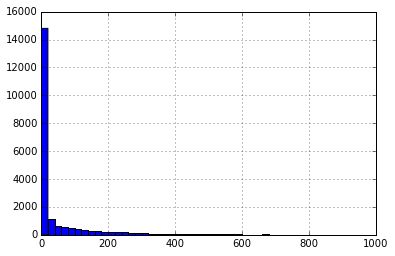

In [57]:
ek_info.query('N>1')['dist_delta'].hist(range=(0,1000),bins=50)

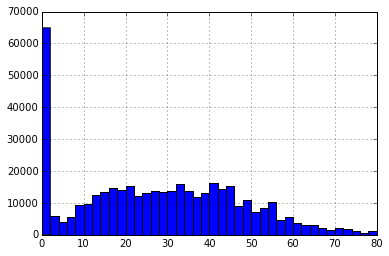

In [58]:
# how many stops were estimated for each trip data group?
pd.Series(lens).hist(range=(0,80),bins=40)

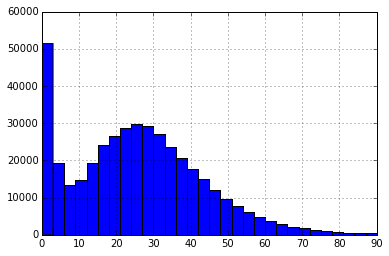

In [59]:
# how many pings were available for each trip data group?
gb.size().hist(range=(0,90),bins=30)